## Clustering

In [22]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# also import these "new" libraries 
# Note: you may have to download and add them to your environment (using e.g. 'conda install -c conda-forge folium')
# !important! Install this version of plotly=5.10.0 or else some maps and animations may not render correctly
import plotly.express as px
import folium
from folium import plugins
from folium.plugins import HeatMap
from branca.element import Figure
import haversine as hs

# import the necessary libraries for the machine learning models
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [23]:
# Finished
taxi_df_clustering = pd.read_parquet('data/prepared/taxi_data_prepared.gzip')

#### General Data Prep
Before we can start with the clustering, we add an addtional feature to our clustering dataframe.

In [24]:
# Finished dataframe
taxi_df_clustering

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,trip_total,pickup_centroid_location,dropoff_centroid_location
0,2016-01-01 00:00:00,2016-01-01 00:15:00,900,2.2,17031281900,17031081402,11.65,POINT (-87.642648998 41.8792550844),POINT (-87.6129454143 41.8919715078)
1,2016-01-01 00:00:00,2016-01-01 00:00:00,480,0.0,17031081700,17031839100,10.05,POINT (-87.6318639497 41.8920421365),POINT (-87.6327464887 41.8809944707)
2,2016-01-01 00:00:00,2016-01-01 00:15:00,900,3.0,17031841000,17031320100,12.05,POINT (-87.6241352979 41.84924675450001),POINT (-87.6209929134 41.8849871918)
3,2016-01-01 00:00:00,2016-01-01 00:15:00,600,1.8,17031320100,17031833100,8.45,POINT (-87.6209929134 41.8849871918),POINT (-87.657005027 41.8790669938)
4,2016-01-01 00:00:00,2016-01-01 00:00:00,600,0.0,17031838300,17031320100,8.25,POINT (-87.6384040116 41.9015669095),POINT (-87.6209929134 41.8849871918)
...,...,...,...,...,...,...,...,...,...
20356204,2016-12-31 23:45:00,2017-01-01 00:00:00,780,0.0,17031839100,17031080202,9.50,POINT (-87.6327464887 41.8809944707),POINT (-87.6308650266 41.9058577688)
20356205,2016-12-31 23:45:00,2017-01-01 00:00:00,780,2.4,17031841000,17031320100,11.75,POINT (-87.6241352979 41.84924675450001),POINT (-87.6209929134 41.8849871918)
20356206,2016-12-31 23:45:00,2017-01-01 00:00:00,1020,4.2,17031081500,17031070200,18.30,POINT (-87.6262149064 41.8925077809),POINT (-87.6462934762 41.9290776551)
20356207,2016-12-31 23:45:00,2017-01-01 00:00:00,720,0.7,17031839100,17031320400,12.50,POINT (-87.6327464887 41.8809944707),POINT (-87.6219716519 41.8774061234)


#### Functions to use for Clustering
Next we create a number of functions to help with frequent Clustering Steps:

In [25]:
# This function is used to standardize features
def scalingData(dataframe):
    newDataframe = dataframe.copy()
    scaler = StandardScaler()
    newDataframe[newDataframe.columns] = pd.DataFrame(scaler.fit_transform(newDataframe[newDataframe.columns]))
    return newDataframe

In [26]:
# This function calculates the Loss per cluster amount and plots the result of it in the range of 0-10 on the x-axis
def calcAndPlotLossKM(clusterAmount, dataframe):
    k_max = clusterAmount

    clusters = []
    losses = []

    for k in range(k_max):
        model = KMeans(n_clusters=k+1, n_init=10)
        model.fit(dataframe)
        clusters.append(k+1)
        losses.append(model.inertia_)

    fig = plt.subplots(figsize=(12,7))
    plt.plot(clusters, losses)
    plt.ylabel("Loss")
    plt.xlabel("Number of clusters")
    plt.xlim([0,10])
    plt.grid(True)
    plt.show()

In [27]:
# This function calculates for a the defined amount of clusters KMeans on the given dataframe
def calcKMeans(numClusters, dataframe):
    result = KMeans(n_clusters=numClusters, n_init=10)
    result.fit(dataframe)

    dataframe['ClusterKM'] = result.predict(dataframe)

In [28]:
# This function describes every KMeans cluster with the describe() function for the original dataframe
def describeData(originalDataframe, scaledDataframe, numClusters):   
    for i in range(0, numClusters):
        display(originalDataframe[scaledDataframe['Cluster'] == i].describe())

### Clustering Trip/Customer Types

To cluster for Trip/Customer Types we will use the following features in context of the hour of day and weekday:
 - Total number of trips for each hour on each weekday
 - Average Trip Duration in seconds for each hour on each weekday
 - Average Trip Distance in miles for each hour on each weekday

In [29]:
#Additional Data of weekday etc
taxi_df_clustering.loc[:,"month"] = taxi_df_clustering["trip_start_timestamp"].dt.month
taxi_df_clustering.loc[:,"weekday"] = taxi_df_clustering["trip_start_timestamp"].dt.weekday
taxi_df_clustering.loc[:,"day"] = taxi_df_clustering["trip_start_timestamp"].dt.day
taxi_df_clustering.loc[:,"hour"] = taxi_df_clustering["trip_start_timestamp"].dt.hour

taxi_df_clustering

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,trip_total,pickup_centroid_location,dropoff_centroid_location,month,weekday,day,hour
0,2016-01-01 00:00:00,2016-01-01 00:15:00,900,2.2,17031281900,17031081402,11.65,POINT (-87.642648998 41.8792550844),POINT (-87.6129454143 41.8919715078),1,4,1,0
1,2016-01-01 00:00:00,2016-01-01 00:00:00,480,0.0,17031081700,17031839100,10.05,POINT (-87.6318639497 41.8920421365),POINT (-87.6327464887 41.8809944707),1,4,1,0
2,2016-01-01 00:00:00,2016-01-01 00:15:00,900,3.0,17031841000,17031320100,12.05,POINT (-87.6241352979 41.84924675450001),POINT (-87.6209929134 41.8849871918),1,4,1,0
3,2016-01-01 00:00:00,2016-01-01 00:15:00,600,1.8,17031320100,17031833100,8.45,POINT (-87.6209929134 41.8849871918),POINT (-87.657005027 41.8790669938),1,4,1,0
4,2016-01-01 00:00:00,2016-01-01 00:00:00,600,0.0,17031838300,17031320100,8.25,POINT (-87.6384040116 41.9015669095),POINT (-87.6209929134 41.8849871918),1,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20356204,2016-12-31 23:45:00,2017-01-01 00:00:00,780,0.0,17031839100,17031080202,9.50,POINT (-87.6327464887 41.8809944707),POINT (-87.6308650266 41.9058577688),12,5,31,23
20356205,2016-12-31 23:45:00,2017-01-01 00:00:00,780,2.4,17031841000,17031320100,11.75,POINT (-87.6241352979 41.84924675450001),POINT (-87.6209929134 41.8849871918),12,5,31,23
20356206,2016-12-31 23:45:00,2017-01-01 00:00:00,1020,4.2,17031081500,17031070200,18.30,POINT (-87.6262149064 41.8925077809),POINT (-87.6462934762 41.9290776551),12,5,31,23
20356207,2016-12-31 23:45:00,2017-01-01 00:00:00,720,0.7,17031839100,17031320400,12.50,POINT (-87.6327464887 41.8809944707),POINT (-87.6219716519 41.8774061234),12,5,31,23


In [30]:
#Count number of trips per weekday and hour
taxi_df_clustering_wd_hr = taxi_df_clustering.groupby(['weekday','hour'])['hour'].count().reset_index(name='n_trips')

#Aggregate trip duration and distance by weekday and hour
taxi_df_clustering_agg = taxi_df_clustering.groupby(['weekday','hour']).agg({'trip_seconds': 'sum', 'trip_miles': 'sum'}).reset_index()

#Merge both new dataframes
taxi_df_clustering_merged = pd.merge(taxi_df_clustering_agg, taxi_df_clustering_wd_hr)

#Calculate average trip duration and distance
taxi_df_clustering_merged['avg_trip_duration'] = taxi_df_clustering_merged['trip_seconds']/taxi_df_clustering_merged['n_trips']
taxi_df_clustering_merged['avg_trip_distance'] = taxi_df_clustering_merged['trip_miles']/taxi_df_clustering_merged['n_trips']

taxi_df_clustering_merged

,weekday,hour,trip_seconds,trip_miles,n_trips,avg_trip_duration,avg_trip_distance
0,0,0,22739048,143167.61,39316,578.366263,3.641459
1,0,1,12367175,69521.81,23471,526.912999,2.962030
2,0,2,5971608,31327.13,13144,454.321972,2.383379
3,0,3,4013208,26069.59,7794,514.909931,3.344828
4,0,4,8130051,101421.21,9144,889.113189,11.091558
...,...,...,...,...,...,...,...
163,6,19,79973156,413939.99,106349,751.987851,3.892279
164,6,20,64910329,381760.49,88989,729.419692,4.289974
165,6,21,57335260,364414.95,80923,708.516244,4.503231
166,6,22,48371990,299349.09,73461,658.471706,4.074939


In [31]:
#Create DF to be used for clustering
taxi_df_customer_types_cluster = taxi_df_clustering_merged[['n_trips','avg_trip_duration','avg_trip_distance']]
taxi_df_customer_types_cluster

,n_trips,avg_trip_duration,avg_trip_distance
0,39316,578.366263,3.641459
1,23471,526.912999,2.962030
2,13144,454.321972,2.383379
3,7794,514.909931,3.344828
4,9144,889.113189,11.091558
...,...,...,...
163,106349,751.987851,3.892279
164,88989,729.419692,4.289974
165,80923,708.516244,4.503231
166,73461,658.471706,4.074939


## Hard Clustering KMeans

In [32]:
#Scaling the Data
taxi_df_customer_types_cluster_scaled = scalingData(taxi_df_customer_types_cluster)
taxi_df_customer_types_cluster_scaled

,n_trips,avg_trip_duration,avg_trip_distance
0,-1.142055,-1.042622,-0.199025
1,-1.363135,-1.389073,-0.526900
2,-1.507225,-1.877852,-0.806141
3,-1.581872,-1.469894,-0.342172
4,-1.563036,1.049738,3.396193
...,...,...,...
163,-0.206764,0.126429,-0.077986
164,-0.448983,-0.025530,0.113931
165,-0.561525,-0.166280,0.216843
166,-0.665640,-0.503246,0.010160


E:\Programme\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


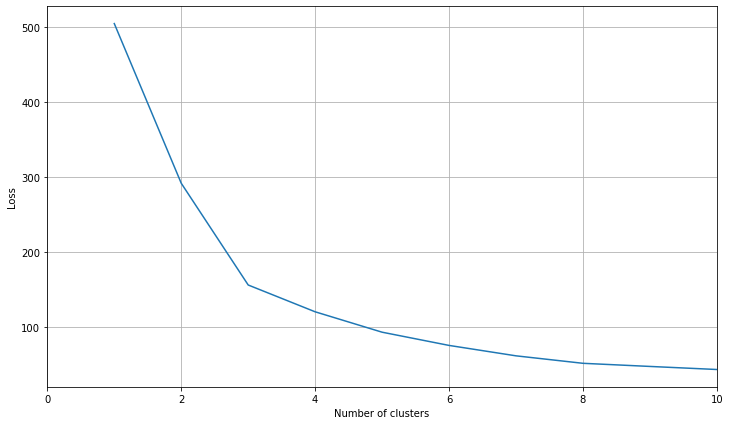

In [33]:
#Calculating the Loss with increasing number of Clusters
calcAndPlotLossKM(10, taxi_df_customer_types_cluster_scaled)

In [34]:
# Define the cluster amount here
cluster = 4

# Calculating KMeans
calcKMeans(cluster, taxi_df_customer_types_cluster_scaled)

# Adding the clusters from KMeans into the original dataframe 
taxi_df_clustering_merged.loc[:, 'ClusterKM'] = taxi_df_customer_types_cluster_scaled['ClusterKM']
taxi_df_clustering_merged

,weekday,hour,trip_seconds,trip_miles,n_trips,avg_trip_duration,avg_trip_distance,ClusterKM
0,0,0,22739048,143167.61,39316,578.366263,3.641459,2
1,0,1,12367175,69521.81,23471,526.912999,2.962030,2
2,0,2,5971608,31327.13,13144,454.321972,2.383379,2
3,0,3,4013208,26069.59,7794,514.909931,3.344828,2
4,0,4,8130051,101421.21,9144,889.113189,11.091558,1
...,...,...,...,...,...,...,...,...
163,6,19,79973156,413939.99,106349,751.987851,3.892279,3
164,6,20,64910329,381760.49,88989,729.419692,4.289974,3
165,6,21,57335260,364414.95,80923,708.516244,4.503231,3
166,6,22,48371990,299349.09,73461,658.471706,4.074939,2


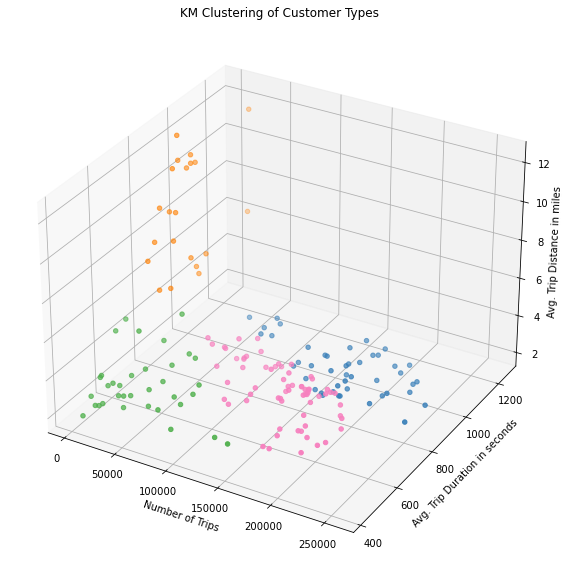

In [35]:
#Plotting the Clustering in 3D
fig = plt.figure(figsize=(10, 10))

# Colors to map to clusters
colors = {0:'#377eb8', 1:'#ff7f00', 2:'#4daf4a', 3:'#f781bf'}
ax = fig.add_subplot(projection='3d')

ax.scatter(xs=taxi_df_clustering_merged['n_trips'], ys=taxi_df_clustering_merged['avg_trip_duration'], zs=taxi_df_clustering_merged['avg_trip_distance'], c=taxi_df_clustering_merged['ClusterKM'].map(colors))

#handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
#ax.legend(title='Cluster', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('KM Clustering of Customer Types')
plt.xlabel('Number of Trips')
plt.ylabel('Avg. Trip Duration in seconds')
ax.set_zlabel('Avg. Trip Distance in miles')
ax.zaxis.labelpad = 0
plt.show()

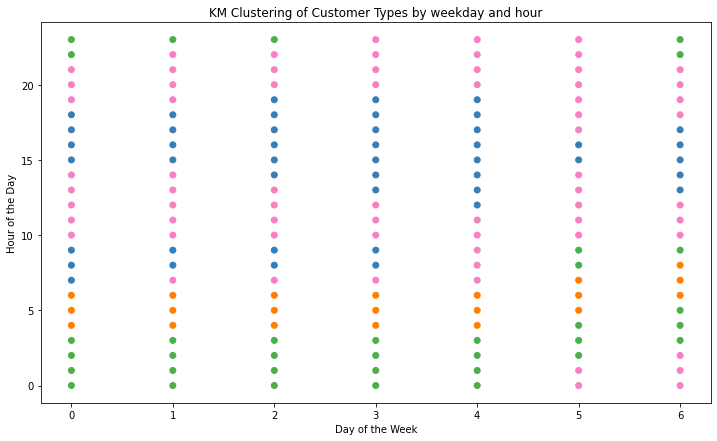

In [36]:
#Plot the cluster result by hour and weekday
plt.figure(figsize=(12,7))

# Colors to map to clusters
colors = {0:'#377eb8', 1:'#ff7f00', 2:'#4daf4a', 3:'#f781bf'}

plt.scatter(x=taxi_df_clustering_merged['weekday'], y=taxi_df_clustering_merged['hour'], c=taxi_df_clustering_merged['ClusterKM'].map(colors))

#handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
#plt.legend(title='Cluster', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('KM Clustering of Customer Types by weekday and hour')
plt.xlabel('Day of the Week')
plt.ylabel('Hour of the Day')
plt.show()

## Soft Clustering with Gaussian Mixture 

In [37]:
# GMM with 4 Clusters
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(taxi_df_customer_types_cluster_scaled)
labels = gmm.predict(taxi_df_customer_types_cluster_scaled)

In [38]:
labels

array([2, 2, 2, 2, 3, 3, 3, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 2, 2, 2, 2, 2, 3, 3, 3, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 2, 2, 2, 2, 2, 3, 3, 3, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 2, 2, 2, 2, 3, 3, 3, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2, 2, 3, 3, 3, 2, 2, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 3, 3, 3, 2,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 2, 2], dtype=int64)

In [39]:
# Adding the clusters from KMeans into the original dataframe 
taxi_df_clustering_merged.loc[:, 'ClusterGMM'] = labels
taxi_df_clustering_merged

,weekday,hour,trip_seconds,trip_miles,n_trips,avg_trip_duration,avg_trip_distance,ClusterKM,ClusterGMM
0,0,0,22739048,143167.61,39316,578.366263,3.641459,2,2
1,0,1,12367175,69521.81,23471,526.912999,2.962030,2,2
2,0,2,5971608,31327.13,13144,454.321972,2.383379,2,2
3,0,3,4013208,26069.59,7794,514.909931,3.344828,2,2
4,0,4,8130051,101421.21,9144,889.113189,11.091558,1,3
...,...,...,...,...,...,...,...,...,...
163,6,19,79973156,413939.99,106349,751.987851,3.892279,3,0
164,6,20,64910329,381760.49,88989,729.419692,4.289974,3,0
165,6,21,57335260,364414.95,80923,708.516244,4.503231,3,0
166,6,22,48371990,299349.09,73461,658.471706,4.074939,2,2


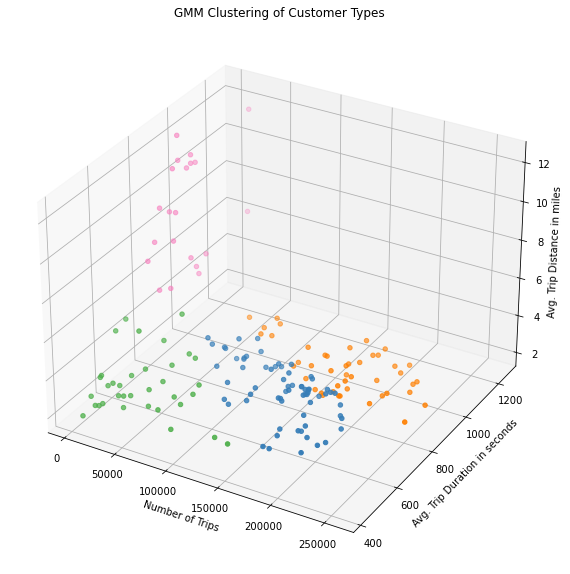

In [40]:
#Plotting the Clustering in 3D
fig = plt.figure(figsize=(10, 10))

# Colors to map to clusters
colors = {0:'#377eb8', 1:'#ff7f00', 2:'#4daf4a', 3:'#f781bf'}
ax = fig.add_subplot(projection='3d')

ax.scatter(xs=taxi_df_clustering_merged['n_trips'], ys=taxi_df_clustering_merged['avg_trip_duration'], zs=taxi_df_clustering_merged['avg_trip_distance'], c=taxi_df_clustering_merged['ClusterGMM'].map(colors))

#handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
#ax.legend(title='Cluster', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('GMM Clustering of Customer Types')
plt.xlabel('Number of Trips')
plt.ylabel('Avg. Trip Duration in seconds')
ax.set_zlabel('Avg. Trip Distance in miles')
ax.zaxis.labelpad = 0
plt.show()

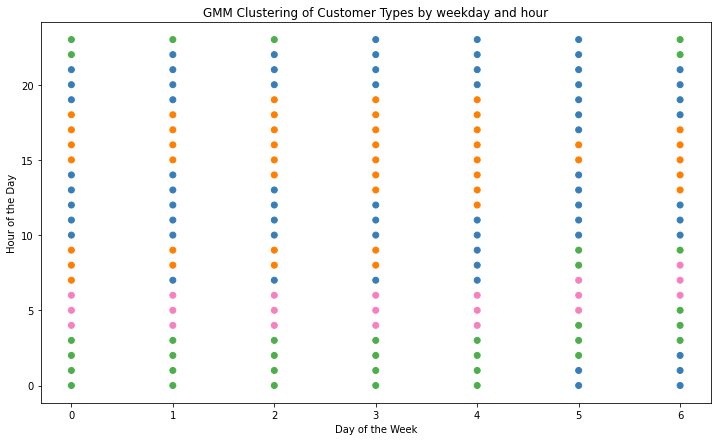

In [41]:
#Plot the cluster result by hour and weekday
plt.figure(figsize=(12,7))

# Colors to map to clusters
colors = {0:'#377eb8', 1:'#ff7f00', 2:'#4daf4a', 3:'#f781bf'}

plt.scatter(x=taxi_df_clustering_merged['weekday'], y=taxi_df_clustering_merged['hour'], c=taxi_df_clustering_merged['ClusterGMM'].map(colors))

#handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
#plt.legend(title='Cluster', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('GMM Clustering of Customer Types by weekday and hour')
plt.xlabel('Day of the Week')
plt.ylabel('Hour of the Day')
plt.show()